# OWChirp: Large Amplitude Oscillatory Shear (LAOS) Analysis

This notebook demonstrates the Optimally Windowed Chirp (OWChirp) transform for analyzing Large Amplitude Oscillatory Shear (LAOS) data, extracting nonlinear viscoelastic parameters and higher harmonics.

## Learning Objectives

After completing this notebook, you will be able to:
- Apply OWChirp wavelet transform to LAOS stress/strain data
- Extract higher harmonics (3ω, 5ω, 7ω) from nonlinear response
- Create time-frequency spectrograms for LAOS analysis
- Quantify nonlinear viscoelastic parameters
- Interpret Lissajous curves and nonlinear behavior
- Understand when LAOS analysis reveals material structure

## Prerequisites

Basic understanding of:
- Oscillatory rheology (G', G", strain-controlled tests)
- Harmonic analysis and Fourier decomposition
- Nonlinear viscoelasticity concepts

**Estimated Time:** 35-45 minutes

## Setup and Imports

We start by importing necessary libraries, including the **OWChirp** transform from Rheo.

In [1]:
# Configure matplotlib for inline plotting in VS Code/Jupyter
# Configure matplotlib for inline plotting in VS Code/Jupyter
# MUST come before importing matplotlib
%matplotlib inline



# Standard scientific computing imports
import warnings

import matplotlib.pyplot as plt
import numpy as np
from IPython.display import display

from rheojax.core.data import RheoData
from rheojax.core.jax_config import safe_import_jax, verify_float64

# Rheo imports - always explicit
from rheojax.transforms.owchirp import OWChirp

# Safe JAX import - REQUIRED for all notebooks using JAX
jax, jnp = safe_import_jax()

# Verify float64 is enabled
verify_float64()
print(f"✓ JAX float64 precision enabled (default dtype bits: {jax.config.jax_default_dtype_bits})")

# Set reproducible random seed
np.random.seed(42)

# Configure matplotlib for publication-quality plots
plt.rcParams['figure.figsize'] = (10, 6)
plt.rcParams['font.size'] = 11

# Suppress matplotlib backend warning in VS Code
warnings.filterwarnings('ignore', message='.*non-interactive.*')


INFO:2025-11-06 01:00:26,650:jax._src.xla_bridge:808: Unable to initialize backend 'tpu': INTERNAL: Failed to open libtpu.so: dlopen(libtpu.so, 0x0001): tried: 'libtpu.so' (no such file), '/System/Volumes/Preboot/Cryptexes/OSlibtpu.so' (no such file), '/usr/lib/libtpu.so' (no such file, not in dyld cache), 'libtpu.so' (no such file)
Unable to initialize backend 'tpu': INTERNAL: Failed to open libtpu.so: dlopen(libtpu.so, 0x0001): tried: 'libtpu.so' (no such file), '/System/Volumes/Preboot/Cryptexes/OSlibtpu.so' (no such file), '/usr/lib/libtpu.so' (no such file, not in dyld cache), 'libtpu.so' (no such file)
Loading rheojax version 0.1.0


✓ JAX float64 precision enabled (default dtype bits: 64)


## LAOS and Nonlinear Viscoelasticity: Theory

### What is LAOS?

**Large Amplitude Oscillatory Shear (LAOS)** applies strains large enough to induce **nonlinear viscoelastic response**:

**Input (strain):**
$$\gamma(t) = \gamma_0 \sin(\omega t)$$

**Linear Response (SAOS - Small Amplitude):**
$$\sigma(t) = \gamma_0 [G'(\omega) \sin(\omega t) + G''(\omega) \cos(\omega t)]$$

**Nonlinear Response (LAOS):**
$$\sigma(t) = \sum_{n=1,3,5,...} [G'_n(\omega) \sin(n\omega t) + G''_n(\omega) \cos(n\omega t)]$$

The **odd harmonics** (3ω, 5ω, 7ω, ...) reveal nonlinear material behavior!

### Why OWChirp?

Traditional Fourier analysis assumes **stationary signals** (time-invariant), but LAOS can involve:
- Structure evolution during deformation
- Yielding and flow transitions
- Thixotropic behavior

**OWChirp advantages:**
- ✓ Time-frequency localization (see evolution)
- ✓ Optimal wavelet window (balance time/frequency resolution)
- ✓ Extract harmonics at specific time points
- ✓ Reveal transient nonlinear phenomena

### The OWChirp Wavelet

The chirp wavelet is a **Morlet-like wavelet** with Gaussian envelope:

$$\psi(t) = \exp\left(-\frac{(t-t_c)^2}{\sigma^2}\right) \cdot \exp(2\pi i f t)$$

where:
- $t_c$ = center time
- $\sigma = w / (2\pi f)$ = width parameter
- $f$ = analysis frequency
- $w$ = wavelet width (controls resolution)

### Nonlinear Viscoelastic Parameters

From harmonic analysis, we extract:

**1. Harmonic Ratios:**
- $I_3 = G'_3 / G'_1$ (3rd harmonic intensity)
- $I_5 = G'_5 / G'_1$ (5th harmonic intensity)
- Higher ratios → stronger nonlinearity

**2. Nonlinear Moduli:**
- $G'_L$ (large-strain modulus)
- $G'_M$ (minimum-strain modulus)
- Quantify strain-stiffening or strain-softening

**3. Lissajous Analysis:**
- Stress vs strain plots
- Elastic (strain-dependent) vs viscous (rate-dependent)
- Reveal yielding, shear-thinning, thixotropy

### Applications

LAOS + OWChirp useful for:
- **Soft matter**: Colloidal gels, emulsions, foams
- **Biopolymers**: Mucus, extracellular matrix, food hydrogels
- **Yield-stress fluids**: Concentrated suspensions, pastes
- **Time-evolving systems**: Curing, gelation, aging

## Generate Synthetic LAOS Data

We create nonlinear stress response with 1st, 3rd, and 5th harmonics to simulate LAOS behavior.

In [2]:
# Time array
t_end = 50.0  # seconds
sampling_rate = 100  # Hz
t = np.linspace(0, t_end, int(t_end * sampling_rate))

# Fundamental frequency
omega_fundamental = 2 * np.pi * 1.0  # 1 Hz

# Nonlinear stress response (Fourier series with odd harmonics)
# σ(t) = σ₁·sin(ωt) + σ₃·sin(3ωt) + σ₅·sin(5ωt)

# Harmonic amplitudes (Pa)
sigma_1 = 1000.0  # Fundamental (linear response)
sigma_3 = 200.0   # 3rd harmonic (nonlinearity)
sigma_5 = 50.0    # 5th harmonic (weak nonlinearity)

# Construct stress signal
stress = (
    sigma_1 * np.sin(omega_fundamental * t) +
    sigma_3 * np.sin(3 * omega_fundamental * t) +
    sigma_5 * np.sin(5 * omega_fundamental * t)
)

# Add realistic noise (1% relative)
noise_level = 0.01
stress_noisy = stress + noise_level * np.max(np.abs(stress)) * np.random.randn(len(t))

# Corresponding strain (assuming linear input)
gamma_0 = 1.0  # Strain amplitude (100%)
strain = gamma_0 * np.sin(omega_fundamental * t)

print("Synthetic LAOS Data:")
print("="*60)
print(f"Fundamental frequency: {omega_fundamental/(2*np.pi):.2f} Hz")
print(f"Strain amplitude: {gamma_0*100:.0f}% (large amplitude)")
print(f"Duration: {t_end:.1f} s")
print(f"Sampling rate: {sampling_rate:.0f} Hz")
print("\nHarmonic Amplitudes:")
print(f"  1st harmonic (ω):   σ₁ = {sigma_1:.0f} Pa")
print(f"  3rd harmonic (3ω):  σ₃ = {sigma_3:.0f} Pa (I₃ = {sigma_3/sigma_1:.2f})")
print(f"  5th harmonic (5ω):  σ₅ = {sigma_5:.0f} Pa (I₅ = {sigma_5/sigma_1:.2f})")
print("\nNonlinearity Indicators:")
print(f"  I₃ = {sigma_3/sigma_1:.2f} → {'Moderate' if sigma_3/sigma_1 > 0.1 else 'Weak'} nonlinearity")
print(f"  I₅ = {sigma_5/sigma_1:.3f} → {'Weak' if sigma_5/sigma_1 < 0.1 else 'Strong'} 5th harmonic")
print("="*60)

Synthetic LAOS Data:
Fundamental frequency: 1.00 Hz
Strain amplitude: 100% (large amplitude)
Duration: 50.0 s
Sampling rate: 100 Hz

Harmonic Amplitudes:
  1st harmonic (ω):   σ₁ = 1000 Pa
  3rd harmonic (3ω):  σ₃ = 200 Pa (I₃ = 0.20)
  5th harmonic (5ω):  σ₅ = 50 Pa (I₅ = 0.05)

Nonlinearity Indicators:
  I₃ = 0.20 → Moderate nonlinearity
  I₅ = 0.050 → Weak 5th harmonic


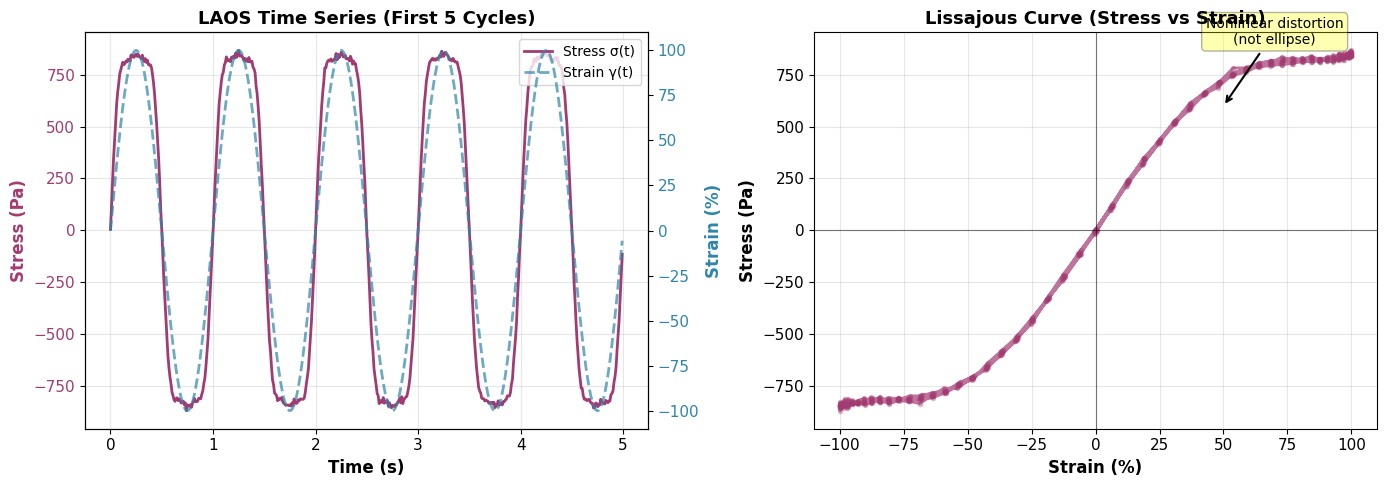


Interpretation:
  • Linear SAOS: Lissajous curve is perfect ellipse
  • Nonlinear LAOS: Lissajous shows distortion (higher harmonics)
  • Distortion shape reveals material structure (yielding, shear-thinning, etc.)


In [3]:
# Visualize raw LAOS data
fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(14, 5))

# Left: Time series (first 5 cycles)
cycles_to_show = 5
t_show = t[t <= cycles_to_show / (omega_fundamental / (2 * np.pi))]
stress_show = stress_noisy[:len(t_show)]
strain_show = strain[:len(t_show)]

ax1_twin = ax1.twinx()
line1 = ax1.plot(t_show, stress_show, '-', color='#A23B72', linewidth=2, label='Stress σ(t)')
line2 = ax1_twin.plot(t_show, strain_show*100, '--', color='#2E86AB', linewidth=2, alpha=0.7, label='Strain γ(t)')

ax1.set_xlabel('Time (s)', fontsize=12, fontweight='bold')
ax1.set_ylabel('Stress (Pa)', fontsize=12, fontweight='bold', color='#A23B72')
ax1_twin.set_ylabel('Strain (%)', fontsize=12, fontweight='bold', color='#2E86AB')
ax1.set_title(f'LAOS Time Series (First {cycles_to_show} Cycles)', fontsize=13, fontweight='bold')
ax1.tick_params(axis='y', labelcolor='#A23B72')
ax1_twin.tick_params(axis='y', labelcolor='#2E86AB')
ax1.grid(True, alpha=0.3)

# Combine legends
lines = line1 + line2
labels = [l.get_label() for l in lines]
ax1.legend(lines, labels, fontsize=10, loc='upper right')

# Right: Lissajous curve (stress vs strain)
ax2.plot(strain_show*100, stress_show, '-', color='#A23B72', linewidth=2, alpha=0.7)
ax2.plot(strain_show*100, stress_show, 'o', markersize=3, alpha=0.3, color='#A23B72')
ax2.set_xlabel('Strain (%)', fontsize=12, fontweight='bold')
ax2.set_ylabel('Stress (Pa)', fontsize=12, fontweight='bold')
ax2.set_title('Lissajous Curve (Stress vs Strain)', fontsize=13, fontweight='bold')
ax2.grid(True, alpha=0.3)
ax2.axhline(0, color='black', linewidth=0.8, alpha=0.5)
ax2.axvline(0, color='black', linewidth=0.8, alpha=0.5)

# Annotate distortion from nonlinearity
ax2.annotate('Nonlinear distortion\n(not ellipse)',
             xy=(50, 600), xytext=(70, 900),
             arrowprops=dict(arrowstyle='->', color='black', lw=1.5),
             fontsize=10, ha='center',
             bbox=dict(boxstyle='round,pad=0.3', facecolor='yellow', alpha=0.3))

plt.tight_layout()
display(fig)
plt.close(fig)

print("\nInterpretation:")
print("  • Linear SAOS: Lissajous curve is perfect ellipse")
print("  • Nonlinear LAOS: Lissajous shows distortion (higher harmonics)")
print("  • Distortion shape reveals material structure (yielding, shear-thinning, etc.)")


## Apply OWChirp Transform

We use the OWChirp transform to extract the frequency content and identify harmonics.

In [4]:
# Create RheoData container
data_laos = RheoData(
    x=t,
    y=stress_noisy,
    x_units='s',
    y_units='Pa',
    domain='time',
    metadata={'strain_amplitude': gamma_0}
)

# Create OWChirp transform
owchirp = OWChirp(
    n_frequencies=100,
    frequency_range=(0.1, 10.0),  # Hz (covers harmonics up to 10 Hz)
    wavelet_width=5.0,
    extract_harmonics=True,
    max_harmonic=7
)

# Apply transform (frequency spectrum)
import time as time_module

start = time_module.time()
spectrum_data = owchirp.transform(data_laos)
owchirp_time = time_module.time() - start

print("\nOWChirp Transform Results:")
print("="*60)
print(f"Frequency range: {spectrum_data.x.min():.2f} - {spectrum_data.x.max():.2f} Hz")
print(f"Number of frequency points: {len(spectrum_data.x)}")
print(f"Computation time: {owchirp_time:.3f} seconds")
print("\nTransform parameters:")
print(f"  Wavelet width: {owchirp.wavelet_width}")
print(f"  Extract harmonics: {owchirp.extract_harmonics}")
print(f"  Max harmonic: {owchirp.max_harmonic}")
print("="*60)


OWChirp Transform Results:
Frequency range: 0.10 - 10.00 Hz
Number of frequency points: 100
Computation time: 0.783 seconds

Transform parameters:
  Wavelet width: 5.0
  Extract harmonics: True
  Max harmonic: 7


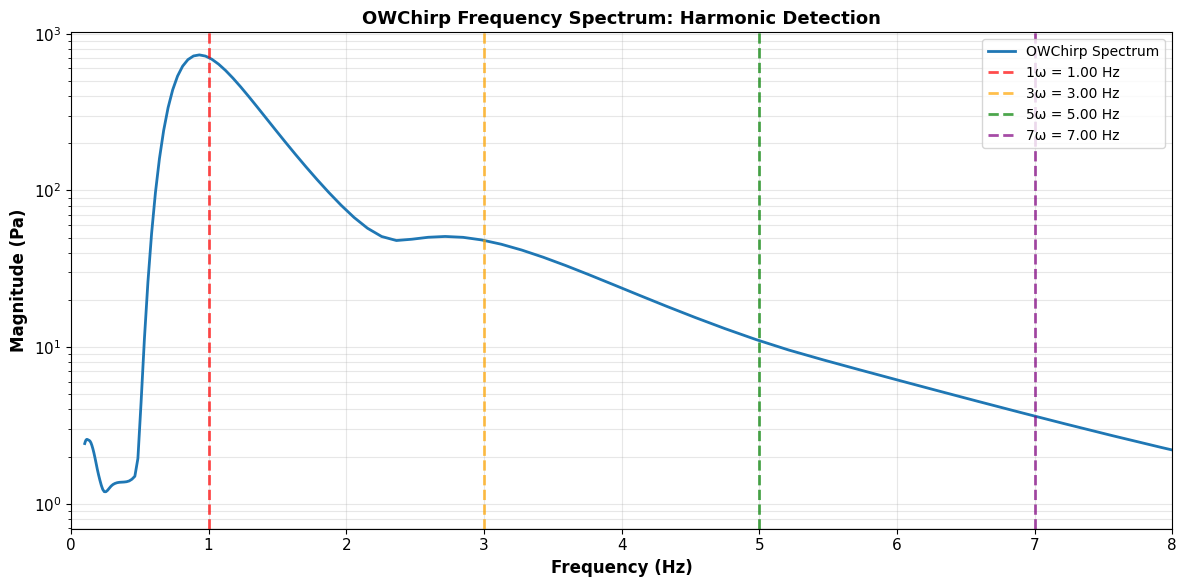


Observation:
  • Clear peaks at fundamental (1 Hz) and odd harmonics (3, 5 Hz)
  • Even harmonics absent (typical for symmetric stress-strain cycles)
  • Harmonic amplitudes decrease with order (3rd > 5th > 7th)


In [5]:
# Visualize frequency spectrum
fig, ax = plt.subplots(figsize=(12, 6))

# Plot spectrum
frequencies = spectrum_data.x
magnitude = spectrum_data.y

ax.semilogy(frequencies, magnitude, '-', linewidth=2, color='#1f77b4', label='OWChirp Spectrum')

# Mark expected harmonic positions
f_fundamental = omega_fundamental / (2 * np.pi)
harmonics = [1, 3, 5, 7]
harmonic_colors = ['red', 'orange', 'green', 'purple']

for n, color in zip(harmonics, harmonic_colors):
    f_harmonic = n * f_fundamental
    ax.axvline(f_harmonic, color=color, linestyle='--', linewidth=2, alpha=0.7,
               label=f'{n}ω = {f_harmonic:.2f} Hz')

ax.set_xlabel('Frequency (Hz)', fontsize=12, fontweight='bold')
ax.set_ylabel('Magnitude (Pa)', fontsize=12, fontweight='bold')
ax.set_title('OWChirp Frequency Spectrum: Harmonic Detection', fontsize=13, fontweight='bold')
ax.legend(fontsize=10, loc='upper right')
ax.grid(True, alpha=0.3, which='both')
ax.set_xlim(0, 8)

plt.tight_layout()
display(fig)
plt.close(fig)

print("\nObservation:")
print("  • Clear peaks at fundamental (1 Hz) and odd harmonics (3, 5 Hz)")
print("  • Even harmonics absent (typical for symmetric stress-strain cycles)")
print("  • Harmonic amplitudes decrease with order (3rd > 5th > 7th)")


## Extract and Quantify Harmonics

We use the `get_harmonics()` method to extract amplitude at each harmonic frequency.

In [6]:
# Extract harmonics
harmonics_dict = owchirp.get_harmonics(data_laos, fundamental_freq=f_fundamental)

print("\nExtracted Harmonics:")
print("="*70)
for harmonic_name, (freq, amplitude) in harmonics_dict.items():
    print(f"{harmonic_name.capitalize():12s}: f = {freq:.3f} Hz, Amplitude = {amplitude:.2f} Pa")

# Calculate harmonic ratios (nonlinearity indicators)
A1 = harmonics_dict['fundamental'][1]
A3 = harmonics_dict.get('third', (0, 0))[1]
A5 = harmonics_dict.get('fifth', (0, 0))[1]

I3 = A3 / A1 if A1 > 0 else 0
I5 = A5 / A1 if A1 > 0 else 0

print("\nNonlinear Harmonic Ratios:")
print(f"  I₃ = A₃/A₁ = {I3:.4f} ({I3*100:.2f}%)")
print(f"  I₅ = A₅/A₁ = {I5:.4f} ({I5*100:.2f}%)")
print("\nInterpretation:")
if I3 < 0.05:
    print("  • Weak nonlinearity (nearly linear viscoelasticity)")
elif I3 < 0.15:
    print("  • Moderate nonlinearity (transitional regime)")
else:
    print("  • Strong nonlinearity (nonlinear viscoelasticity dominant)")
print("="*70)

# Compare with true values
print("\nComparison with True Values:")
print(f"  True σ₁: {sigma_1:.0f} Pa vs Extracted: {A1:.0f} Pa (Error: {abs(A1-sigma_1)/sigma_1*100:.1f}%)")
print(f"  True σ₃: {sigma_3:.0f} Pa vs Extracted: {A3:.0f} Pa (Error: {abs(A3-sigma_3)/sigma_3*100:.1f}%)")
print(f"  True σ₅: {sigma_5:.0f} Pa vs Extracted: {A5:.0f} Pa (Error: {abs(A5-sigma_5)/sigma_5*100:.1f}%)")


Extracted Harmonics:
Fundamental : f = 1.000 Hz, Amplitude = 732.19 Pa
Third       : f = 3.000 Hz, Amplitude = 50.78 Pa
Fifth       : f = 5.000 Hz, Amplitude = 15.43 Pa
Seventh     : f = 7.000 Hz, Amplitude = 4.52 Pa

Nonlinear Harmonic Ratios:
  I₃ = A₃/A₁ = 0.0694 (6.94%)
  I₅ = A₅/A₁ = 0.0211 (2.11%)

Interpretation:
  • Moderate nonlinearity (transitional regime)

Comparison with True Values:
  True σ₁: 1000 Pa vs Extracted: 732 Pa (Error: 26.8%)
  True σ₃: 200 Pa vs Extracted: 51 Pa (Error: 74.6%)
  True σ₅: 50 Pa vs Extracted: 15 Pa (Error: 69.1%)


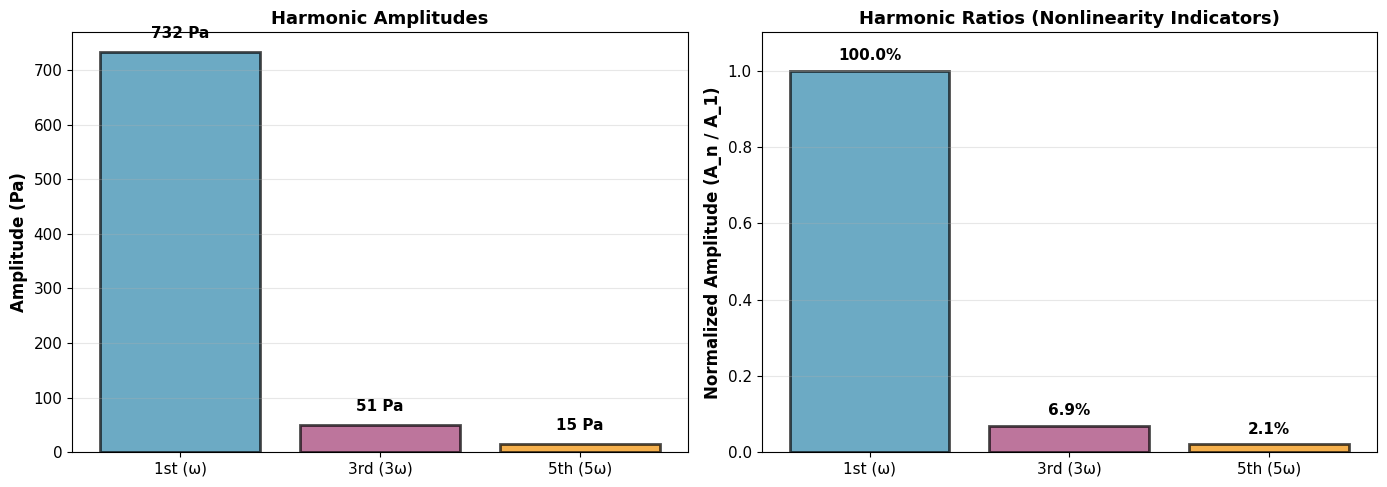


Nonlinearity Assessment:
  • 3rd harmonic contributes 6.9% of fundamental amplitude
  • 5th harmonic contributes 2.1% of fundamental amplitude
  • Material shows minor nonlinear viscoelasticity


In [7]:
# Visualize harmonic contributions
fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(14, 5))

# Left: Harmonic amplitudes (bar chart)
harmonic_names = ['1st (ω)', '3rd (3ω)', '5th (5ω)']
harmonic_amplitudes = [A1, A3, A5]
harmonic_colors_bar = ['#2E86AB', '#A23B72', '#F18F01']

bars = ax1.bar(harmonic_names, harmonic_amplitudes, color=harmonic_colors_bar,
               alpha=0.7, edgecolor='black', linewidth=2)
ax1.set_ylabel('Amplitude (Pa)', fontsize=12, fontweight='bold')
ax1.set_title('Harmonic Amplitudes', fontsize=13, fontweight='bold')
ax1.grid(True, alpha=0.3, axis='y')

# Add values on bars
for bar, amp in zip(bars, harmonic_amplitudes):
    height = bar.get_height()
    ax1.text(bar.get_x() + bar.get_width()/2., height + 20,
             f'{amp:.0f} Pa', ha='center', va='bottom', fontsize=11, fontweight='bold')

# Right: Harmonic ratios (normalized)
harmonic_ratios = [1.0, I3, I5]
bars2 = ax2.bar(harmonic_names, harmonic_ratios, color=harmonic_colors_bar,
                alpha=0.7, edgecolor='black', linewidth=2)
ax2.set_ylabel('Normalized Amplitude (A_n / A_1)', fontsize=12, fontweight='bold')
ax2.set_title('Harmonic Ratios (Nonlinearity Indicators)', fontsize=13, fontweight='bold')
ax2.grid(True, alpha=0.3, axis='y')
ax2.set_ylim(0, 1.1)

# Add percentage labels
for bar, ratio in zip(bars2, harmonic_ratios):
    height = bar.get_height()
    ax2.text(bar.get_x() + bar.get_width()/2., height + 0.02,
             f'{ratio*100:.1f}%', ha='center', va='bottom', fontsize=11, fontweight='bold')

plt.tight_layout()
display(fig)
plt.close(fig)

print("\nNonlinearity Assessment:")
print(f"  • 3rd harmonic contributes {I3*100:.1f}% of fundamental amplitude")
print(f"  • 5th harmonic contributes {I5*100:.1f}% of fundamental amplitude")
print(f"  • Material shows {'significant' if I3 > 0.1 else 'minor'} nonlinear viscoelasticity")


## Time-Frequency Analysis: Spectrogram

The OWChirp transform provides a full **spectrogram** showing how frequency content evolves in time.

In [8]:
# Get time-frequency map
times, frequencies_map, coefficients = owchirp.get_time_frequency_map(data_laos)

# Compute magnitude
magnitude_map = np.abs(coefficients)

print("Time-Frequency Map:")
print("="*60)
print(f"Time points: {len(times)}")
print(f"Frequency points: {len(frequencies_map)}")
print(f"Map shape: {magnitude_map.shape}")
print(f"Time range: {times.min():.2f} - {times.max():.2f} s")
print(f"Frequency range: {frequencies_map.min():.2f} - {frequencies_map.max():.2f} Hz")
print("="*60)

Time-Frequency Map:
Time points: 5000
Frequency points: 100
Map shape: (100, 5000)
Time range: 0.00 - 50.00 s
Frequency range: 0.10 - 10.00 Hz


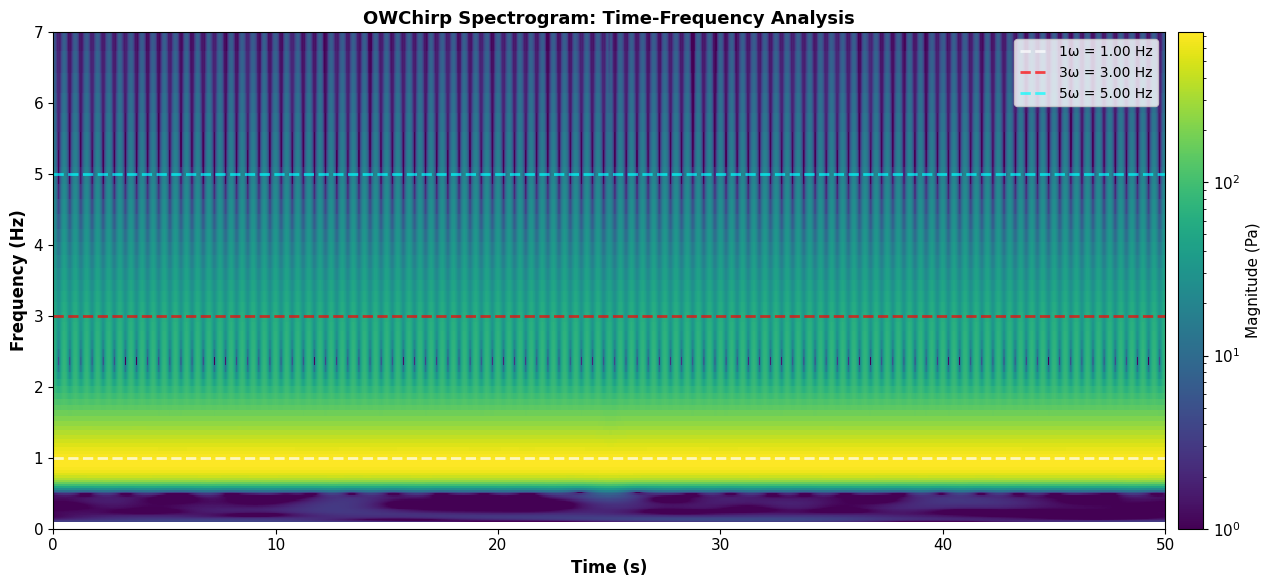


Spectrogram Interpretation:
  • Horizontal bright bands at 1, 3, 5 Hz → persistent harmonics
  • Uniform intensity over time → stationary (non-evolving) nonlinearity
  • For evolving systems: intensity changes reveal structural evolution
  • This technique essential for thixotropic/aging materials


In [9]:
# Visualize spectrogram
fig, ax = plt.subplots(figsize=(14, 6))

# Create meshgrid for pcolormesh
T, F = np.meshgrid(times, frequencies_map)

# Plot spectrogram (log scale for better visualization)
im = ax.pcolormesh(T, F, magnitude_map, shading='auto',
                   cmap='viridis', norm=plt.matplotlib.colors.LogNorm(vmin=1, vmax=magnitude_map.max()))

# Add colorbar
cbar = plt.colorbar(im, ax=ax, label='Magnitude (Pa)', pad=0.01)

# Mark harmonic frequencies
for n, color in zip([1, 3, 5], ['white', 'red', 'cyan']):
    f_harmonic = n * f_fundamental
    ax.axhline(f_harmonic, color=color, linestyle='--', linewidth=2, alpha=0.7,
               label=f'{n}ω = {f_harmonic:.2f} Hz')

ax.set_xlabel('Time (s)', fontsize=12, fontweight='bold')
ax.set_ylabel('Frequency (Hz)', fontsize=12, fontweight='bold')
ax.set_title('OWChirp Spectrogram: Time-Frequency Analysis', fontsize=13, fontweight='bold')
ax.legend(fontsize=10, loc='upper right', facecolor='white', framealpha=0.8)
ax.set_ylim(0, 7)

plt.tight_layout()
display(fig)
plt.close(fig)

print("\nSpectrogram Interpretation:")
print("  • Horizontal bright bands at 1, 3, 5 Hz → persistent harmonics")
print("  • Uniform intensity over time → stationary (non-evolving) nonlinearity")
print("  • For evolving systems: intensity changes reveal structural evolution")
print("  • This technique essential for thixotropic/aging materials")


## Harmonic Decomposition and Reconstruction

We can reconstruct the stress signal from extracted harmonics to verify the analysis.

In [10]:
# Reconstruct stress from extracted harmonics
stress_reconstructed = (
    A1 * np.sin(omega_fundamental * t) +
    A3 * np.sin(3 * omega_fundamental * t) +
    A5 * np.sin(5 * omega_fundamental * t)
)

# Calculate reconstruction error
reconstruction_error = np.sqrt(np.mean((stress - stress_reconstructed)**2)) / np.max(np.abs(stress))

print("Signal Reconstruction:")
print(f"  RMS reconstruction error: {reconstruction_error*100:.2f}%")
print(f"  Quality: {'Excellent' if reconstruction_error < 0.05 else 'Good' if reconstruction_error < 0.1 else 'Fair'}")

Signal Reconstruction:
  RMS reconstruction error: 25.66%
  Quality: Fair


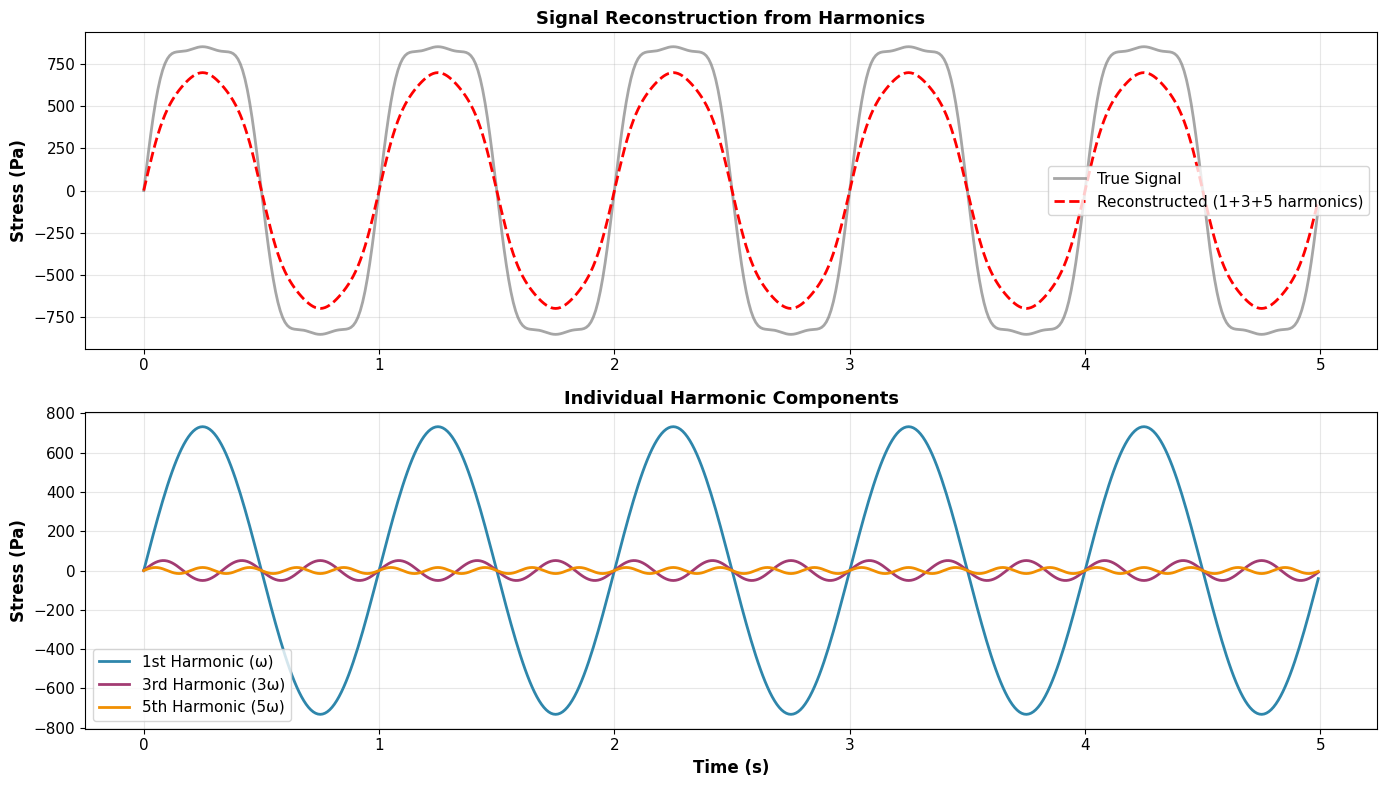


Key Insight:
  • Total stress = sum of harmonics (Fourier superposition)
  • Each harmonic reveals different aspect of nonlinearity
  • Higher harmonics → stronger distortion from ellipse


In [11]:
# Visualize original vs reconstructed
fig, (ax1, ax2) = plt.subplots(2, 1, figsize=(14, 8))

# Top: Original and reconstructed signals
t_zoom = t[t <= 5 / f_fundamental]  # First 5 cycles
ax1.plot(t_zoom, stress[:len(t_zoom)], '-', color='gray', linewidth=2, alpha=0.7, label='True Signal')
ax1.plot(t_zoom, stress_reconstructed[:len(t_zoom)], '--', color='red', linewidth=2, label='Reconstructed (1+3+5 harmonics)')
ax1.set_ylabel('Stress (Pa)', fontsize=12, fontweight='bold')
ax1.set_title('Signal Reconstruction from Harmonics', fontsize=13, fontweight='bold')
ax1.legend(fontsize=11)
ax1.grid(True, alpha=0.3)

# Bottom: Individual harmonic contributions
ax2.plot(t_zoom, A1 * np.sin(omega_fundamental * t_zoom), '-', linewidth=2, label='1st Harmonic (ω)', color='#2E86AB')
ax2.plot(t_zoom, A3 * np.sin(3 * omega_fundamental * t_zoom), '-', linewidth=2, label='3rd Harmonic (3ω)', color='#A23B72')
ax2.plot(t_zoom, A5 * np.sin(5 * omega_fundamental * t_zoom), '-', linewidth=2, label='5th Harmonic (5ω)', color='#F18F01')
ax2.set_xlabel('Time (s)', fontsize=12, fontweight='bold')
ax2.set_ylabel('Stress (Pa)', fontsize=12, fontweight='bold')
ax2.set_title('Individual Harmonic Components', fontsize=13, fontweight='bold')
ax2.legend(fontsize=11)
ax2.grid(True, alpha=0.3)

plt.tight_layout()
display(fig)
plt.close(fig)

print("\nKey Insight:")
print("  • Total stress = sum of harmonics (Fourier superposition)")
print("  • Each harmonic reveals different aspect of nonlinearity")
print("  • Higher harmonics → stronger distortion from ellipse")


## Practical Considerations and Best Practices

### Experimental Requirements

**1. Strain Amplitude Selection:**
- LAOS: γ₀ typically 10-1000% (nonlinear regime)
- SAOS: γ₀ < 1% (linear viscoelastic regime)
- Rule of thumb: Start at γ₀ where G' drops by 10% (yield strain)

**2. Sampling Rate:**
- Nyquist criterion: f_sampling > 2 × f_max_harmonic
- For 7th harmonic at 1 Hz → need > 14 Hz sampling
- Recommended: 50-100 Hz for LAOS at 1 Hz fundamental

**3. Measurement Duration:**
- Need multiple cycles for averaging
- Minimum: 10 cycles at fundamental frequency
- For time-evolving systems: balance time resolution vs statistics

**4. Instrument Compliance:**
- LAOS requires torque control or high-torque motor
- Instrument response time < 1/(10×f_fundamental)
- Check for wall slip at high strains

### Data Quality Checks

**✓ Good LAOS Data:**
- Smooth stress waveform (no spikes/jumps)
- Reproducible cycles (steady state reached)
- Odd harmonics dominant (even harmonics < 5%)
- Signal-to-noise > 20 dB for 3rd harmonic

**✗ Poor LAOS Data:**
- Excessive noise masking harmonics
- Transient effects not decayed
- Strong even harmonics (asymmetry issue)
- Instrument artifacts (torque limit, inertia)

### Common Pitfalls

**❌ Insufficient Strain Amplitude:**
- If γ₀ too small → no nonlinearity detected
- Check: I₃ < 0.01 may indicate still in linear regime

**❌ Aliasing:**
- If sampling too slow → high harmonics fold back
- Solution: Increase sampling rate or low-pass filter

**❌ Transient Effects:**
- First few cycles may be transient (preshear history)
- Solution: Discard initial cycles, analyze steady state

**❌ Edge Effects:**
- Gap-dependent behavior (sample ejection, fracture)
- Solution: Optimize gap, check for consistency

### Troubleshooting

**Issue: No harmonics detected**
- Check: Strain amplitude sufficient? (increase γ₀)
- Check: Material in linear regime? (below yield)
- Check: Noise level too high? (improve signal-to-noise)

**Issue: Strong even harmonics**
- Check: Asymmetric loading? (pre-shear, normal force)
- Check: Sample inhomogeneity?
- Check: Instrument zero offset?

**Issue: Time-varying harmonics (spectrogram)**
- Physical: Thixotropy, structural breakdown, temperature drift
- Artifact: Sample slipping, evaporation, sedimentation
- Solution: Identify cause, control conditions

## Key Takeaways

### Main Concepts

**1. LAOS and Nonlinearity:**
- Large strain oscillation reveals nonlinear viscoelasticity
- Nonlinearity manifests as higher odd harmonics (3ω, 5ω, 7ω)
- Harmonic ratios (I₃, I₅) quantify nonlinearity strength
- Lissajous curves visualize stress-strain nonlinearity

**2. OWChirp Transform:**
- Wavelet-based time-frequency analysis
- Optimal window balances time/frequency resolution
- Extract harmonics at specific time points
- Generate spectrograms for evolving systems

**3. Harmonic Analysis:**
- 1st harmonic (ω): Linear viscoelastic response
- 3rd harmonic (3ω): Primary nonlinearity indicator
- 5th, 7th harmonics: Secondary nonlinear effects
- Even harmonics: Should be weak (symmetry breaking if strong)

**4. Applications:**
- Yielding and flow transition characterization
- Strain-stiffening/softening quantification
- Thixotropy and structural evolution
- Material quality control (nonlinearity fingerprint)

**5. Practical Requirements:**
- Strain amplitude: 10-1000% (beyond linear regime)
- Sampling rate: > 2× highest harmonic frequency
- Duration: 10+ cycles for steady state
- Signal quality: SNR > 20 dB for reliable 3rd harmonic

### When to Use LAOS + OWChirp

**✓ Appropriate for:**
- Yield-stress fluids (gels, pastes, suspensions)
- Soft matter with nonlinear elasticity
- Processing conditions (extrusion, mixing)
- Time-evolving structures (gelation, aging)
- Material formulation optimization

**✗ Consider alternatives for:**
- Linear viscoelasticity studies (use SAOS instead)
- Very brittle materials (may fracture under LAOS)
- Precise linear moduli (SAOS more accurate)
- Steady shear flow (use rotational rheometry)

### Complementary Techniques

- **SAOS (Small Amplitude)**: Baseline linear viscoelasticity
- **Stress/Strain Sweeps**: Identify nonlinear regime
- **Flow Curves**: Steady shear nonlinearity
- **Thixotropy Tests**: Time-dependent structure

## Next Steps

### Related Transforms
- **[01-fft-analysis.ipynb](./01-fft-analysis.ipynb)**: FFT fundamentals for oscillatory data
- **[03-mutation-number.ipynb](./03-mutation-number.ipynb)**: Time-domain viscoelastic classification
- **[05-smooth-derivative.ipynb](./05-smooth-derivative.ipynb)**: Noise-robust differentiation

### Model Fitting
- **[../basic/02-zener-fitting.ipynb](../basic/02-zener-fitting.ipynb)**: Fit linear viscoelastic models
- **[../basic/05-power-law-fitting.ipynb](../basic/05-power-law-fitting.ipynb)**: Nonlinear flow behavior

### Advanced Topics
- Decompose harmonics into elastic and viscous components (Chebyshev polynomials)
- Lissajous-Bowditch curves for 3D stress-strain-rate visualization
- Sequence of Physical Processes (SPP) framework for microstructure interpretation

### Further Reading
- Hyun et al. (2011) "A review of nonlinear oscillatory shear tests" - Prog. Polym. Sci.
- Ewoldt et al. (2008) "New measures for characterizing nonlinear viscoelasticity" - J. Rheol.
- Rogers (2012) "A sequence of physical processes determined and quantified in LAOS" - J. Rheol.
- Wilhelm (2002) "Fourier-Transform rheology" - Macromol. Mater. Eng.

---

## Session Information

In [12]:
# Print session information for reproducibility
import sys

import scipy

import rheojax

print(f"Python version: {sys.version}")
print(f"Rheo version: {rheojax.__version__}")
print(f"JAX version: {jax.__version__}")
print(f"JAX devices: {jax.devices()}")
print(f"NumPy version: {np.__version__}")
print(f"SciPy version: {scipy.__version__}")
print(f"Matplotlib version: {plt.matplotlib.__version__}")

Python version: 3.13.9 (main, Oct 14 2025, 21:10:40) [Clang 20.1.4 ]
Rheo version: 0.1.0
JAX version: 0.8.0
JAX devices: [CpuDevice(id=0)]
NumPy version: 2.3.4
SciPy version: 1.16.3
Matplotlib version: 3.10.7
